In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

In [3]:
import optax

In [4]:
class MMD:
    """
    A class to compute the Maximum Mean Discrepancy (MMD) between two distributions
    using a kernel-based approach. The MMD measures the distance between two probability 
    distributions, commonly used in statistics and machine learning for comparing distributions.
    """

    def __init__(self, scales, space):
        """
        Initialize the MMD class with kernel scales and a sample space.

        Parameters:
        - scales (array-like): Bandwidths for the Gaussian kernels.
        - space (array-like): The space of points where the kernel matrix is computed.

        Attributes:
        - K (jnp.array): The combined kernel matrix computed over the sample space.
        - scales (array-like): The input scales for the kernels.
        """
        # Compute the gamma values (inverse variance) for Gaussian kernels
        gammas = 1 / (2 * (scales**2))
        
        # Compute pairwise squared distances in the sample space
        # This creates a distance matrix where sq_dists[i, j] = |space[i] - space[j]|^2
        sq_dists = jnp.abs(space[:, None] - space[None, :]) ** 2

        # Compute the kernel matrix as a sum of Gaussian kernels with different scales
        # Each kernel is weighted equally by dividing by the number of scales
        self.K = sum(jnp.exp(-gamma * sq_dists) for gamma in gammas) / len(scales)
        
        # Store the scales for reference
        self.scales = scales

    def k_expval(self, px, py):
        """
        Compute the kernel expectation value between two distributions.

        Parameters:
        - px (jnp.array): A distribution vector (e.g., probability values) over the sample space.
        - py (jnp.array): Another distribution vector over the sample space.

        Returns:
        - float: The kernel expectation value computed as px^T @ K @ py.
        """
        # Perform the matrix-vector multiplication to compute px^T @ K @ py
        return px @ self.K @ py

    def __call__(self, px, py):
        """
        Compute the MMD distance between two distributions px and py.

        Parameters:
        - px (jnp.array): A distribution vector over the sample space.
        - py (jnp.array): Another distribution vector over the sample space.

        Returns:
        - float: The MMD distance between px and py.
        """
        # Compute the difference between the distributions
        pxy = px - py
        
        # Use the kernel expectation value to compute the MMD distance
        # MMD is essentially the quadratic form of the difference vector with the kernel
        return self.k_expval(pxy, pxy)

In [5]:
class KLDivergence:
    def __init__(self):
        """
        Initializes the KLDivergence class. No specific parameters are needed since
        KL divergence is a function of two probability distributions.
        """
        pass

    def kl_term(self, p, q):
        """
        Computes the per-element KL divergence term: p * log(p / q).
        Assumes p and q are non-negative and sum to 1.
        
        Parameters:
        - p: Probability distribution (jnp.array)
        - q: Probability distribution (jnp.array)

        Returns:
        - KL divergence term: jnp.array
        """
        # Avoid division by zero and log of zero by using a small epsilon
        epsilon = 1e-10
        p_safe = jnp.clip(p, epsilon, 1.0)
        q_safe = jnp.clip(q, epsilon, 1.0)
        return p_safe * jnp.log(p_safe / q_safe)

    def __call__(self, p, q):
        """
        Computes the KL divergence between two distributions.

        Parameters:
        - p: Probability distribution (jnp.array)
        - q: Probability distribution (jnp.array)

        Returns:
        - KL divergence: float
        """
        return jnp.sum(self.kl_term(p, q))

In [6]:
from functools import partial  # Importing 'partial' from functools to create partially evaluated functions

class QCBM:
    """
    A class representing a Quantum-Classical Boltzmann Machine (QCBM). 
    This class includes methods to compute the loss between a quantum circuit's output distribution 
    and a target probability distribution.
    """

    def __init__(self, circ, loss, py):
        """
        Initializes the QCBM model.

        Args:
        - circ (callable): A quantum circuit function that takes parameters and outputs a probability distribution.
        - loss (callable): A function to compute the loss between the output distribution of the quantum circuit 
                            and the target distribution.
        - py (callable): The target probability distribution π(x) that the quantum circuit is trying to approximate.
        """
        self.circ = circ  # Quantum circuit function that returns a probability distribution given certain parameters
        self.loss = loss  # Loss function (such as MMD, KL divergence, etc.) to compare the output of the quantum circuit with the target
        self.py = py      # The target probability distribution (π(x)) the quantum circuit aims to match

    @partial(jax.jit, static_argnums=0)  # Use JAX's JIT compilation for optimizing the 'loss_fn' method
    def loss_fn(self, params):
        """
        Computes the loss between the quantum circuit's output distribution and the target distribution.

        Args:
        - params (array-like): Parameters for the quantum circuit, which define the quantum state.

        Returns:
        - loss (float): The computed loss value between the quantum circuit's output distribution and the target distribution.
        - px (array): The output probability distribution generated by the quantum circuit.
        """
        px = self.circ(params)  # Compute the output distribution (px) from the quantum circuit using the current parameters
        return self.loss(px, self.py), px  # Return the loss between the output distribution px and the target distribution py, along with px itself


In [7]:
@jax.jit
def update_step(params, opt_state):
    (loss_val, qcbm_probs), grads = jax.value_and_grad(qcbm.loss_fn, has_aux=True)(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    kl_div = -jnp.sum(qcbm.py * jnp.nan_to_num(jnp.log(qcbm_probs / qcbm.py)))
    return params, opt_state, loss_val, kl_div

## Mixture of Gaussains

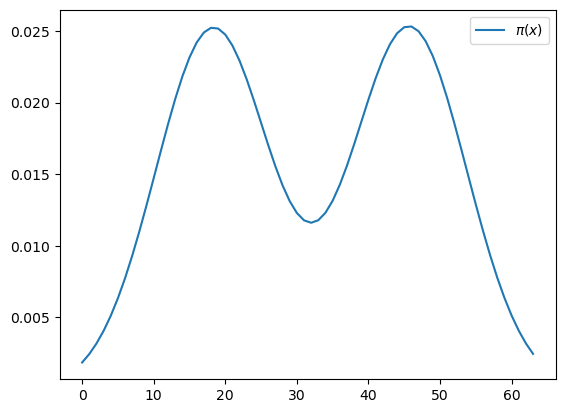

In [8]:
def mixture_gaussian_pdf(x, mus, sigmas):
    mus, sigmas = np.array(mus), np.array(sigmas)
    vars = sigmas**2
    values = [
        (1 / np.sqrt(2 * np.pi * v)) * np.exp(-((x - m) ** 2) / (2 * v)) for m, v in zip(mus, vars)
    ]
    values = np.sum([val / sum(val) for val in values], axis=0)
    return values / np.sum(values)


n_qubits = 6
x_max = 2**n_qubits
x_input = np.arange(x_max)
mus = [(2 / 7) * x_max, (5 / 7) * x_max]
sigmas = [x_max / 8] * 2
data = mixture_gaussian_pdf(x_input, mus, sigmas)

plt.plot(data, label=r"$\pi(x)$")
plt.legend()
plt.show()

### MMD Loss

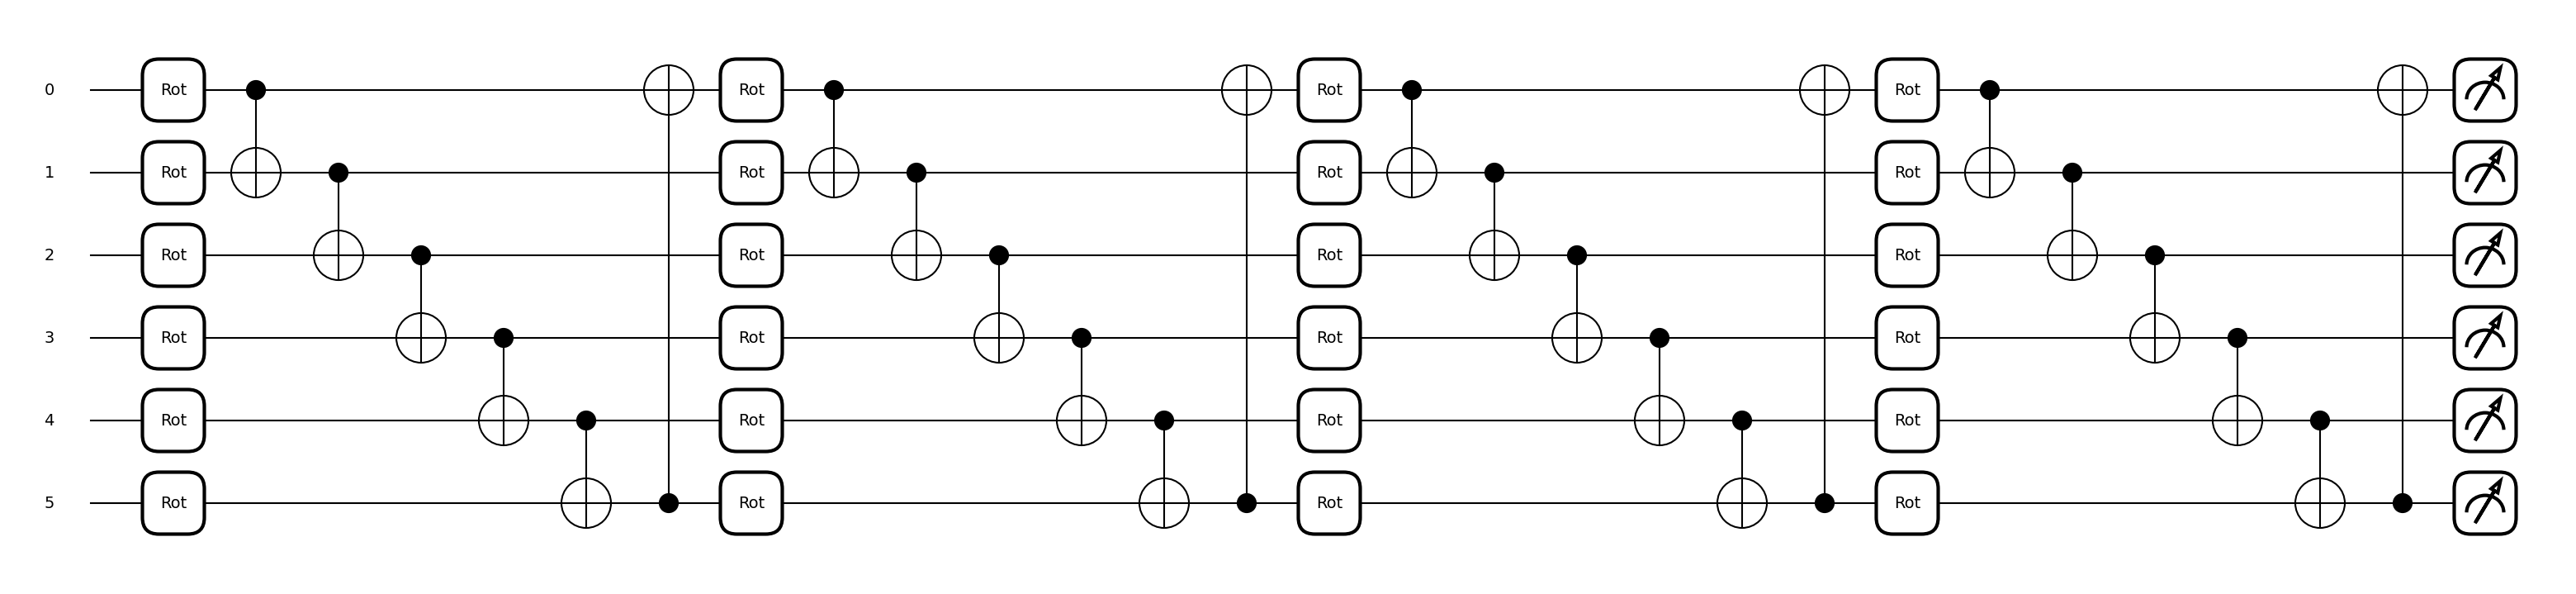

In [9]:
dev = qml.device("default.qubit", wires=n_qubits)

n_layers = 4
wshape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
weights = np.random.random(size=wshape)


@qml.qnode(dev)
def circuit(weights):
    qml.StronglyEntanglingLayers(
        weights=weights, ranges=[1] * n_layers, wires=range(n_qubits)
    )
    return qml.probs()


jit_circuit = jax.jit(circuit)

qml.draw_mpl(circuit, level="device")(weights)
plt.show()

In [10]:
bandwidth = jnp.array([0.25, 60])
space = jnp.arange(2**n_qubits)

mmd = MMD(bandwidth, space)
qcbm = QCBM(jit_circuit, mmd, data)

opt = optax.adam(learning_rate=0.1)
opt_state = opt.init(weights)

history = []
divs = []
n_iterations = 100

for i in range(n_iterations):
    weights, opt_state, loss_val, kl_div = update_step(weights, opt_state)

    if i % 10 == 0:
        print(f"Step: {i} Loss: {loss_val:.4f} KL-div: {kl_div:.4f}")

    history.append(loss_val)
    divs.append(kl_div)

Step: 0 Loss: 0.0145 KL-div: 0.7448
Step: 10 Loss: 0.0031 KL-div: 0.2873
Step: 20 Loss: 0.0015 KL-div: 0.1392
Step: 30 Loss: 0.0009 KL-div: 0.0840
Step: 40 Loss: 0.0006 KL-div: 0.0574
Step: 50 Loss: 0.0004 KL-div: 0.0518
Step: 60 Loss: 0.0004 KL-div: 0.0372
Step: 70 Loss: 0.0003 KL-div: 0.0242
Step: 80 Loss: 0.0002 KL-div: 0.0209
Step: 90 Loss: 0.0002 KL-div: 0.0196


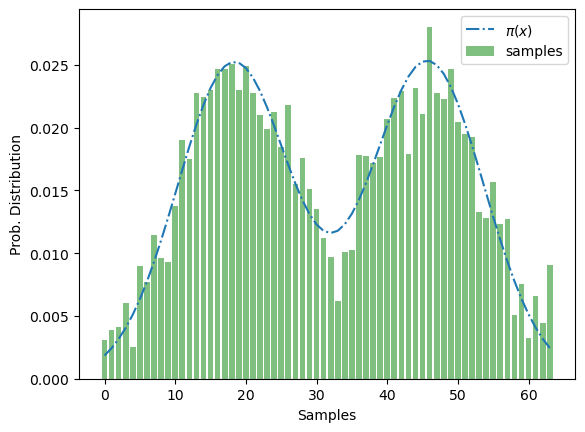

In [11]:
qcbm_probs = qcbm.circ(weights)

plt.plot(range(x_max), data, linestyle="-.", label=r"$\pi(x)$")
plt.bar(range(x_max), qcbm_probs, color="green", alpha=0.5, label="samples")

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")

plt.legend()
plt.show()

## KL Divergence

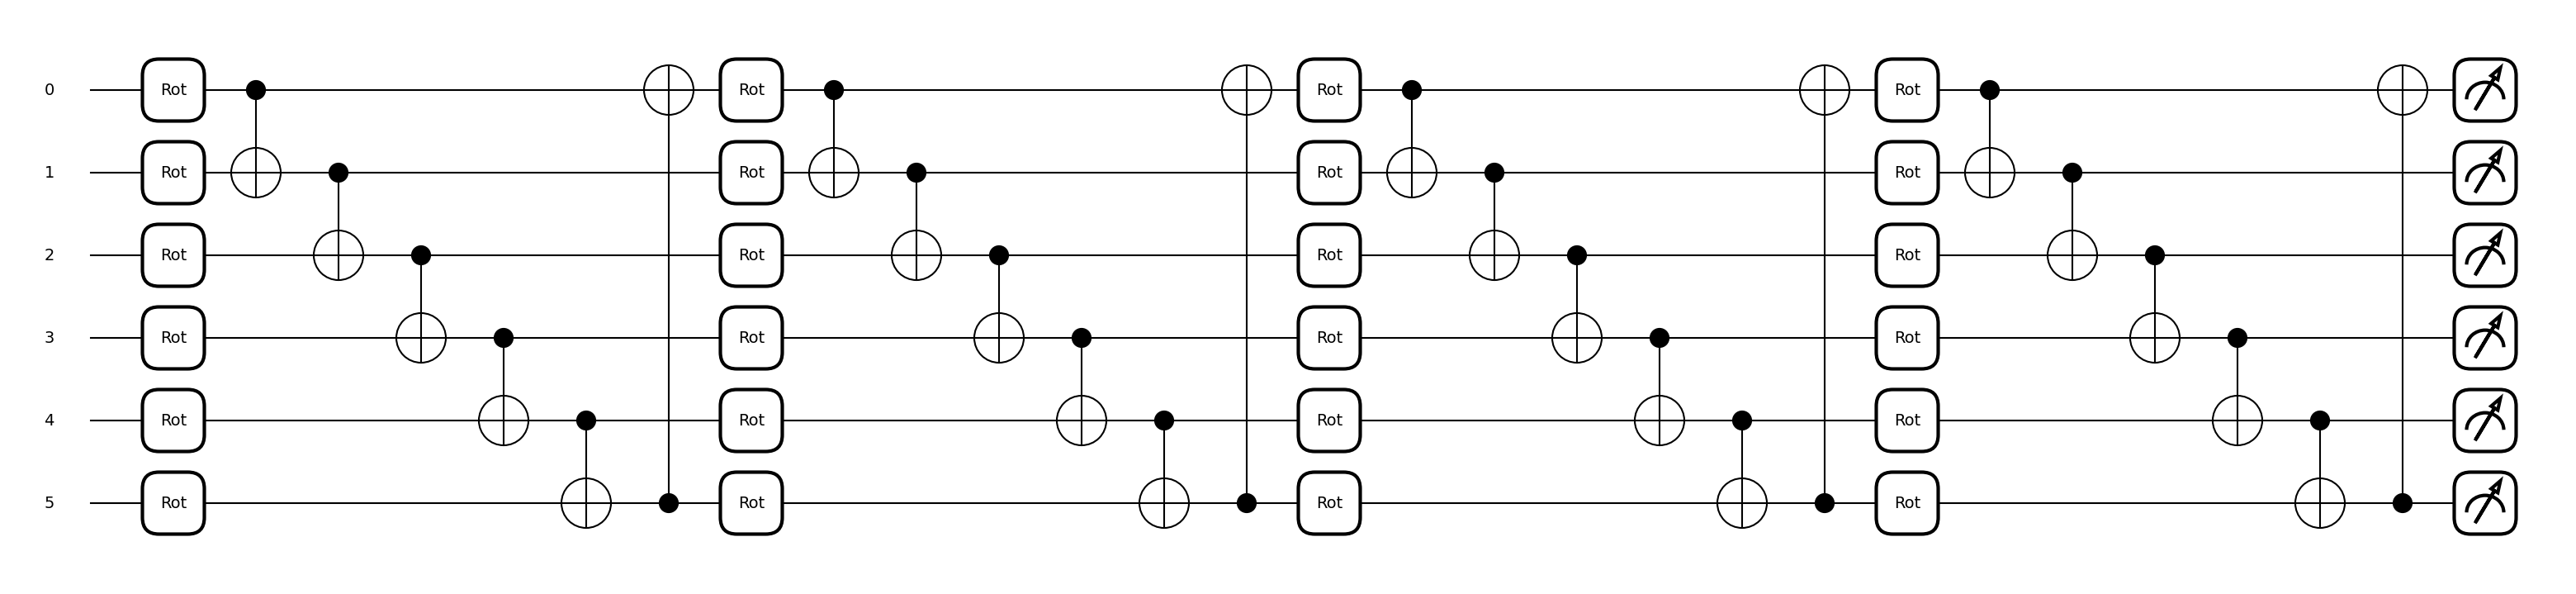

In [12]:
dev = qml.device("default.qubit", wires=n_qubits)

n_layers = 4
wshape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
weights = np.random.random(size=wshape)


@qml.qnode(dev)
def circuit(weights):
    qml.StronglyEntanglingLayers(
        weights=weights, ranges=[1] * n_layers, wires=range(n_qubits)
    )
    return qml.probs()


jit_circuit = jax.jit(circuit)

qml.draw_mpl(circuit, level="device")(weights)
plt.show()

In [13]:
bandwidth = jnp.array([0.25, 60])
space = jnp.arange(2**n_qubits)

kl_loss = KLDivergence()
qcbm = QCBM(jit_circuit, kl_loss, data)

opt = optax.adam(learning_rate=0.1)
opt_state = opt.init(weights)

history = []
divs = []
n_iterations = 100

for i in range(n_iterations):
    weights, opt_state, loss_val, kl_div = update_step(weights, opt_state)

    if i % 10 == 0:
        print(f"Step: {i} Loss: {loss_val:.4f} KL-div: {kl_div:.4f}")

    history.append(loss_val)
    divs.append(kl_div)

Step: 0 Loss: 0.0243 KL-div: 0.7022
Step: 10 Loss: 0.0030 KL-div: 0.2515
Step: 20 Loss: 0.0017 KL-div: 0.1613
Step: 30 Loss: 0.0008 KL-div: 0.1061
Step: 40 Loss: 0.0006 KL-div: 0.0601
Step: 50 Loss: 0.0004 KL-div: 0.0468
Step: 60 Loss: 0.0002 KL-div: 0.0227
Step: 70 Loss: 0.0002 KL-div: 0.0180
Step: 80 Loss: 0.0001 KL-div: 0.0165
Step: 90 Loss: 0.0001 KL-div: 0.0139


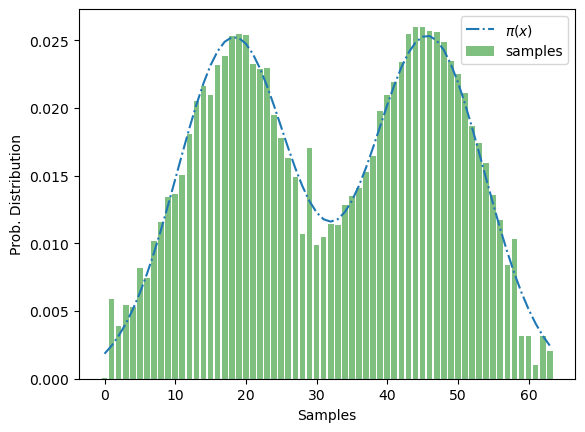

In [14]:
qcbm_probs = qcbm.circ(weights)

plt.plot(range(x_max), data, linestyle="-.", label=r"$\pi(x)$")
plt.bar(range(x_max), qcbm_probs, color="green", alpha=0.5, label="samples")

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")

plt.legend()
plt.show()